In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import ast

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import (
    train_test_split, KFold, RandomizedSearchCV, cross_val_score)
from sklearn.metrics import (r2_score, mean_squared_error, make_scorer)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder
)
from sklearn.model_selection import ParameterSampler

import itertools
import random

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

# Feature Engineering

Import the worker dataset

In [2]:
# Import the dataset
df_workers = pd.read_csv("worker_data.csv")


The function `categorize_mode()` bins together transportation modes based on their significance in the data dictionary.

In [3]:
def categorize_mode(mode):
    if mode in [1,2, 3, 4]:  # Walk, bike, wheelchair/mobility scooter, other non-motorized
        return 'Active Transportation'
    elif mode in [5,8,10]:  # Auto Driver, motorcycle, rental car
        return 'Auto Driver'
    elif mode in [6,7,9]:  # Auto Passenger, Carpool, taxi
        return 'Auto Passenger'
    elif mode in [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]:  # Transit modes
        return 'Transit'
    else:  # Everything else
        return 'Other'

The function `temporal_conversion()` converts the date and departure time into datetime.

In [4]:
def temporal_conversion(data):
    # Combine travel_date and dep_time into a single datetime column
    data['departure_datetime'] = pd.to_datetime(data['travel_date'] + ' ' + data['dep_time'])

    # Drop the original travel_date and dep_time columns if no longer needed
    data = data.drop(columns=['travel_date', 'dep_time']) 

    # Ensure 'departure_datetime' is in datetime format
    data['departure_datetime'] = pd.to_datetime(data['departure_datetime'])

    # Create a new dat of week column with numerical days of week
    data['day_of_week_num'] = data['departure_datetime'].dt.dayofweek

    return data

The `workday_range` in the dataset is a list in string form. Hence,  `convert_list_to_int_or_nan()` checks the contents of the converted list and assign the values as integers used for workday analysis.

In [5]:
# Function to handle 'nan' and numbers in a string list
def convert_list_to_int_or_nan(x):
    if isinstance(x, str):
        # Convert string to list using ast.literal_eval
        x = ast.literal_eval(x)

    # Now process the list, convert numeric strings to int and 'nan' to np.nan
    result = []
    for val in x:
        if isinstance(val, str):
            # If it's a string number (e.g., '5.0', '6.0'), convert to float or int
            if val.lower() != 'nan':
                result.append(int(float(val)))  # Convert numeric string to an integer
            else:
                result.append(np.nan)  # Replace 'nan' string with np.nan
        elif isinstance(val, (float, int)):
            result.append(int(val))  # Convert numeric types to integer
        else:
            result.append(np.nan)  # Handle non-numeric values

    return result

The function `check_workday()` compares the day of the week of the travel time to the days the individual travels to determine whether a trip can be assigned as a worktrip or not.

In [6]:
def check_workday(travel_date, workday_range):
    # If the person works Monday to Friday (8)
    if 8 in workday_range:
        if travel_date == 5 or travel_date == 6:  # Saturday (5) or Sunday (6)
            return 2  # Not a workday
        else:
            return 1  # Monday to Friday is a workday
    # If the person works on specific days in workday_range (1-7)
    elif (travel_date + 1) in workday_range:  # Convert travel_date 0-6 to 1-7 (Monday=1, Sunday=7)
        return 1  # It is a workday
    else:
        return 2  # Not a workday

##### The function `assign_rush_hour()` assigns 1 and 0 to new columns describing whether a particular hour is a rush hour on a given day based on defined boundaries.

In [40]:
def assign_rush_hour(data):
    """
    Assign ordinal values based on the hour of the day.
    """
    # Assign rush hour only to weekdays (0-4)
    # Assign rush hour feature for weekdays (1 = rush hour, 0 = not rush hour)
    data['rush_hour_weekday'] = data.apply(
        lambda row: 1 if (row['day_of_week_num'] < 5 and (7 <= row['hour'] <= 9 or 16 <= row['hour'] <= 19)) else 0,
        axis=1
    )
    
    # Assign rush hour feature for weekends (1 = rush hour, 0 = not rush hour)
    data['rush_hour_weekend'] = data.apply(
        lambda row: 1 if (row['day_of_week_num'] >= 5 and (10 <= row['hour'] <= 15)) else 0,
        axis=1
    )
    return data

`feature_engineering()` includes all the feature engineering performed to transform the given features into ones that would help develop the model and improve it's accuracy. Not all of these avriables will be use in the final model. This will depend on their performance in the model at predicting rider counts.

In [41]:
def feature_engineering(data):
    data_copy = data.copy()

    # Apply the categorization function to the 'Mode of transport' column
    data_copy['mode_category'] = data_copy['mode_category'].astype(int).apply(categorize_mode)

    data_copy = temporal_conversion(data_copy)

    # Extract the day of the month
    data_copy.loc[:, 'day_m'] = data_copy['departure_datetime'].dt.day

    # Extract the hour of the day
    data_copy['hour'] = data_copy['departure_datetime'].dt.hour

    # Transform the hour of the day into cyclical curves which reflects the behaviour of our data
    data_copy['hour_sin'] = np.sin(2 * np.pi * data_copy['hour'] / 24)
    data_copy['hour_cos'] = np.cos(2 * np.pi * data_copy['hour'] / 24)

    # Identify if it is the weekend or not
    data_copy.loc[:, 'weekend'] = data_copy['day_of_week_num'].isin([5, 6]).astype(int)

    # First convert the units column into an actual list
    data_copy.loc[:, 'workday_range'] = data_copy['workday_range'].str.strip("[]").str.replace("'", "").str.split(", ")

    # Apply this function to the 'workday_range' column
    data_copy.loc[:, 'workday_range'] = data_copy['workday_range'].apply(convert_list_to_int_or_nan)

    # Apply the function to the DataFrame
    data_copy['is_workday'] = data_copy.apply(lambda row: check_workday(row['day_of_week_num'], row['workday_range']), axis=1)

    data_copy = assign_rush_hour(data_copy)

    return data_copy

Apply the features to the dataset.

In [42]:
workers_features = feature_engineering(df_workers)

In [43]:
workers_features

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,arr_time,city_from_zip,gender,age,citizen,...,departure_datetime,day_of_week_num,day_m,hour,hour_sin,hour_cos,weekend,is_workday,rush_hour_weekday,rush_hour_weekend
0,3.0,2.0,Auto Driver,20.0,3.619057,08:35:00,Greater Los Angeles Area,1.0,46.0,1.0,...,2012-05-12 08:15:00,5,12,8,0.866025,-5.000000e-01,1,2,0,0
1,5.0,4.0,Auto Driver,20.0,3.587950,15:50:00,Greater Los Angeles Area,1.0,46.0,1.0,...,2012-05-12 15:30:00,5,12,15,-0.707107,-7.071068e-01,1,2,0,1
2,2.0,1.0,Auto Driver,25.0,19.351621,16:55:00,Greater Los Angeles Area,1.0,46.0,1.0,...,2012-05-12 16:30:00,5,12,16,-0.866025,-5.000000e-01,1,2,0,0
3,2.0,1.0,Auto Driver,15.0,6.451126,17:55:00,Greater Los Angeles Area,1.0,46.0,1.0,...,2012-05-12 17:40:00,5,12,17,-0.965926,-2.588190e-01,1,2,0,0
4,2.0,1.0,Auto Driver,20.0,17.657172,19:00:00,Greater Los Angeles Area,1.0,46.0,1.0,...,2012-05-12 18:40:00,5,12,18,-1.000000,-1.836970e-16,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95112,1.0,0.0,Auto Driver,4.0,0.181507,16:02:00,San Francisco Bay Area,1.0,45.0,1.0,...,2013-01-30 15:58:00,2,30,15,-0.707107,-7.071068e-01,0,1,0,0
95113,1.0,0.0,Auto Driver,14.0,2.674467,16:47:00,San Francisco Bay Area,1.0,45.0,1.0,...,2013-01-30 16:33:00,2,30,16,-0.866025,-5.000000e-01,0,1,1,0
95114,1.0,0.0,Active Transportation,17.0,2.621383,17:25:00,San Francisco Bay Area,1.0,45.0,1.0,...,2013-01-30 17:08:00,2,30,17,-0.965926,-2.588190e-01,0,1,1,0
95115,1.0,0.0,Active Transportation,94.0,10.356760,19:17:00,San Francisco Bay Area,1.0,45.0,1.0,...,2013-01-30 17:43:00,2,30,17,-0.965926,-2.588190e-01,0,1,1,0


# Feature Selection

In [44]:
def selected_feature(data):
    
    feature_selected = ['tottr',
                        'rush_hour_weekday',
                        'rush_hour_weekend',
                        'hour_sin',
                        'hour_cos',
                        'weekend',
                        'gender',
                        'race',
                        'age',
                        'citizen',
                        'incentive',
                        'vehicle_count',
                        'income',
                        'worker_count',
                        'is_workday',
                        'workday_count',
                        'driver_license',
                        'job_count',
                        'apparent_temperature_mean (°C)',
                        'WMO_code']

    selected_data = data[feature_selected]
    
    return selected_data

# Model Training

In [45]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(workers_features, test_size=0.3, stratify=workers_features['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the training set
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Step 4: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Driver': 48509, 'Active Transportation': 8419, 'Auto Passenger': 7297, 'Transit': 2058, 'Other': 298})
Class distribution after SMOTE: Counter({'Active Transportation': 48509, 'Auto Driver': 48509, 'Auto Passenger': 48509, 'Transit': 48509, 'Other': 48509})
Training set size: 242545
Validation set size: 14268
Test set size: 14268


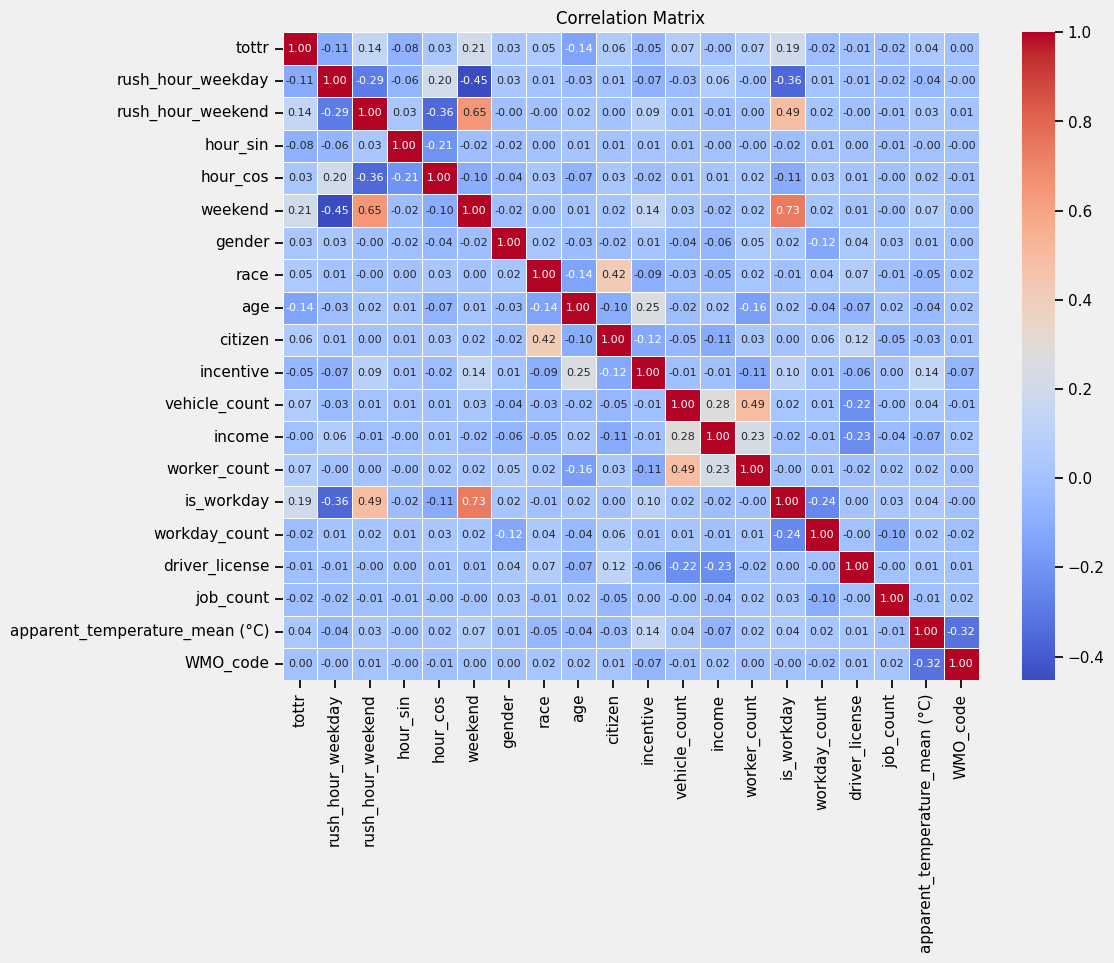

In [46]:
# Perform a correlation matrix on train
correlation_matrix = X_train.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

In [47]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [48]:
y_pred = model.predict(X_val)

# Evaluate Performace of the Model

In [49]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Accuracy of the Random Forest Classifier: 81.88%


In [50]:
# from sklearn.model_selection import cross_val_score

# # Perform cross-validation
# cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)

# print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}%")

In [51]:
from sklearn.metrics import classification_report, f1_score

# Step 1: Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Step 2: Generate classification report
report = classification_report(y_val, y_pred, target_names=['Active Transportation', 'Auto Driver', 'Auto Passenger', 'Other', 'Transit'], digits=3)
print("\nClassification Report:\n", report)

# Step 3: Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': np.int64(1804), 'Auto Driver': np.int64(10395), 'Auto Passenger': np.int64(1564), 'Other': np.int64(64), 'Transit': np.int64(441)}

Classification Report:
                        precision    recall  f1-score   support

Active Transportation      0.610     0.498     0.549      1804
          Auto Driver      0.877     0.946     0.910     10395
       Auto Passenger      0.760     0.566     0.649      1564
                Other      0.222     0.062     0.098        64
              Transit      0.157     0.145     0.151       441

             accuracy                          0.819     14268
            macro avg      0.525     0.444     0.471     14268
         weighted avg      0.806     0.819     0.809     14268


Weighted F1-Score: 0.8087841460479134



Top 10 Important Features:
                           Feature  Importance
0                            tottr    0.182683
18  apparent_temperature_mean (°C)    0.109073
8                              age    0.108922
4                         hour_cos    0.091656
3                         hour_sin    0.083486
19                        WMO_code    0.066090
11                   vehicle_count    0.058632
12                          income    0.054888
6                           gender    0.044075
15                   workday_count    0.042220


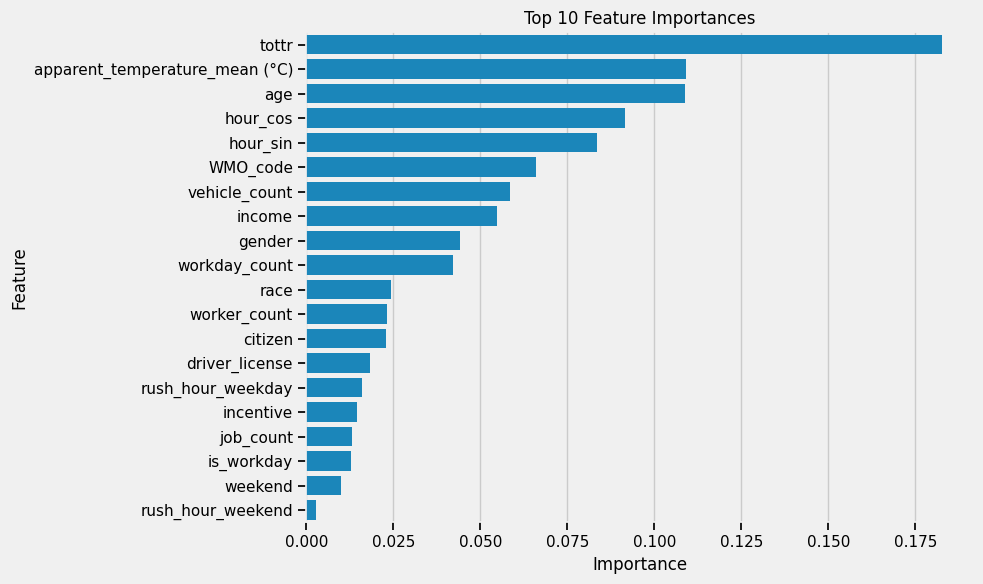

In [54]:
# Feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [53]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

posx and posy should be finite values
posx and posy should be finite values


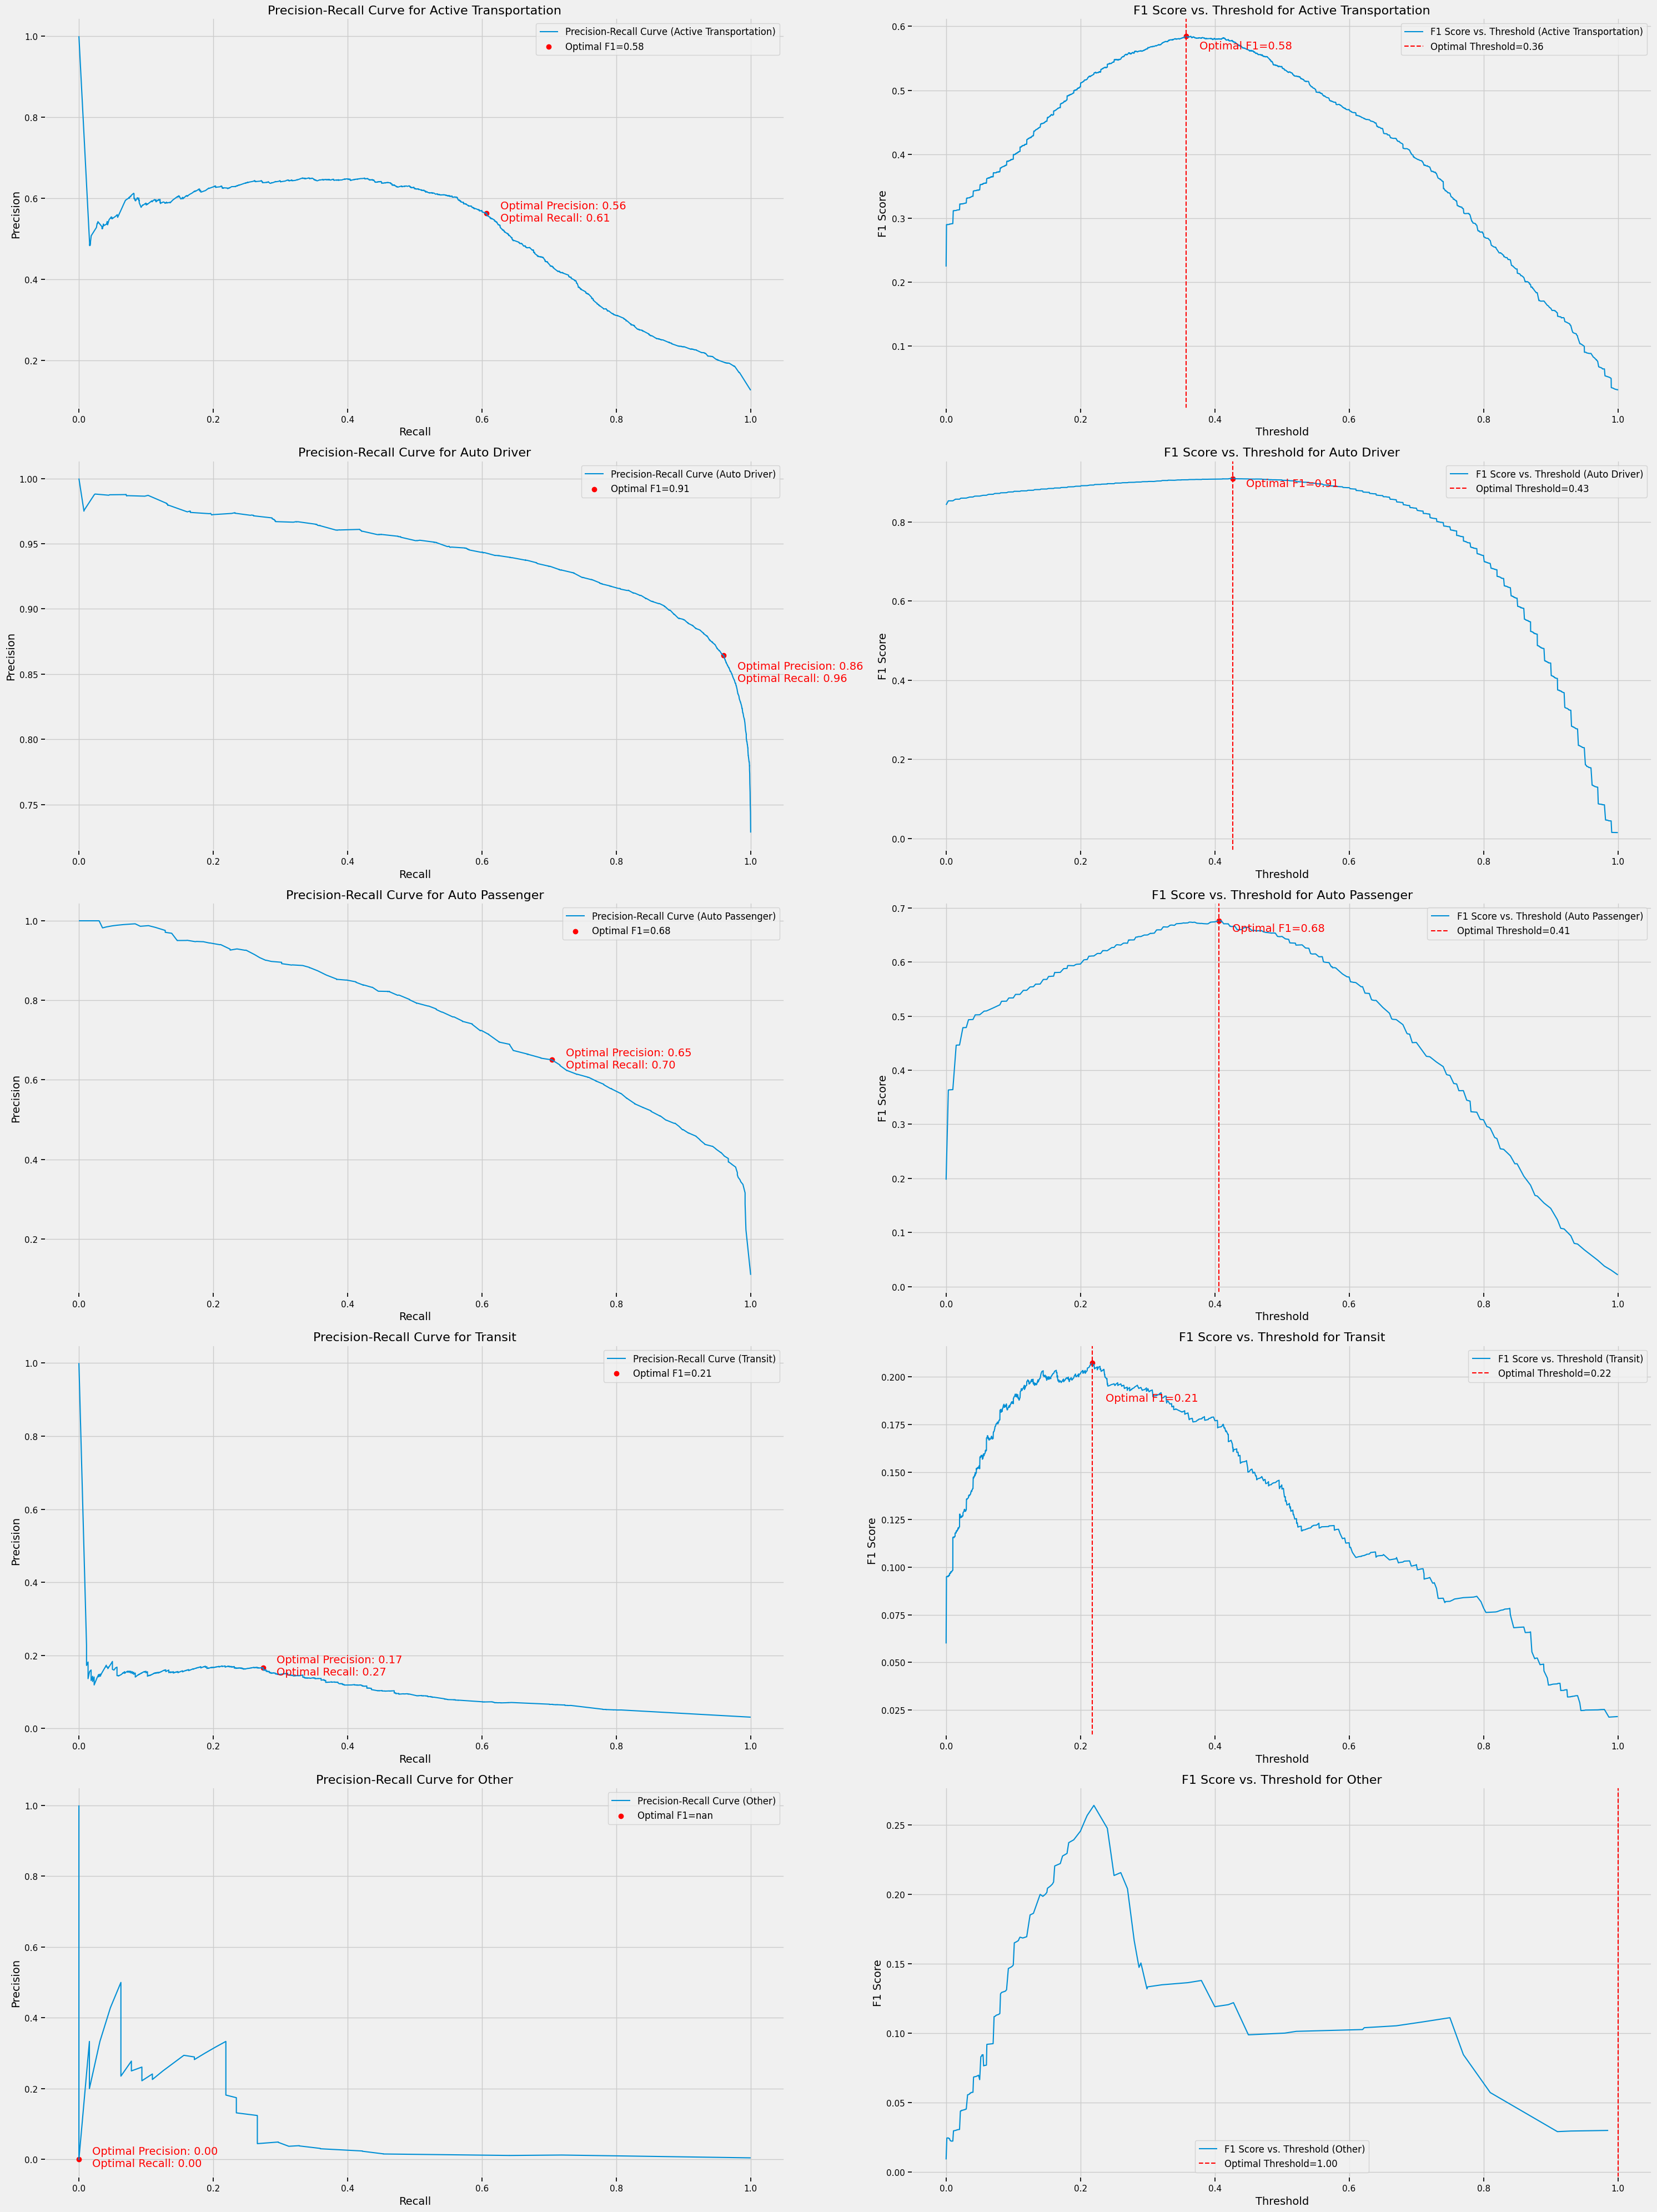

In [76]:
from sklearn.metrics import precision_recall_curve

# List of target classes
target_classes = ['Active Transportation', 'Auto Driver', 'Auto Passenger', 'Transit', 'Other']

# Set up the plot
plt.figure(figsize=(30, 40))

for idx, target_class in enumerate(target_classes):
    # Convert y_val to binary: 1 for the target class, 0 otherwise
    y_binary = (y_val == target_class).astype(int)

    # Predict probabilities for all classes (for RandomForestClassifier, for example)
    y_probs = model.predict_proba(X_val)  # Get probabilities for all classes

    # Identify the index of the target class in the model's classes_
    target_class_index = list(model.classes_).index(target_class)

    # Extract probabilities for the target class
    y_probs_target = y_probs[:, target_class_index]

    # Calculate precision, recall, and thresholds for the Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_binary, y_probs_target)

    # Calculate F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the optimal threshold for the highest F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_f1 = f1_scores[optimal_idx]
    optimal_threshold = thresholds[optimal_idx] if len(thresholds) > 0 else 1  # Handle case when thresholds are empty

    # Subplot 1: Precision-Recall curve for each target class
    plt.subplot(len(target_classes), 2, 2 * idx + 1)
    plt.plot(recall, precision, label=f"Precision-Recall Curve ({target_class})")
    plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Optimal F1={optimal_f1:.2f}')
    plt.text(recall[optimal_idx] + 0.02, precision[optimal_idx] - 0.02, 
             f'Optimal Precision: {precision[optimal_idx]:.2f}\nOptimal Recall: {recall[optimal_idx]:.2f}', 
             color='red', fontsize=14) 
    plt.xlabel('Recall', fontsize=14)  
    plt.ylabel('Precision', fontsize=14)  
    plt.title(f'Precision-Recall Curve for {target_class}', fontsize=16)  
    plt.legend(fontsize=12)  
    plt.grid(True)

    # Subplot 2: F1 vs. Threshold for each target class
    plt.subplot(len(target_classes), 2, 2 * idx + 2)
    plt.plot(thresholds, f1_scores[:-1], label=f"F1 Score vs. Threshold ({target_class})")  # Exclude the last threshold (no corresponding F1 score)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold={optimal_threshold:.2f}')
    plt.scatter(optimal_threshold, optimal_f1, color='red')
    plt.text(optimal_threshold + 0.02, optimal_f1 - 0.02, f'Optimal F1={optimal_f1:.2f}', color='red', fontsize=14) 
    plt.xlabel('Threshold', fontsize=14)  
    plt.ylabel('F1 Score', fontsize=14)  
    plt.title(f'F1 Score vs. Threshold for {target_class}', fontsize=16) 
    plt.legend(fontsize=12)  

# Show the plots
plt.tight_layout()
plt.show()
